# Single-cell RNA Analysis of Liver Cell Atlas
#### James Lee
#### Created on 1/5/2024

In [1]:
library(dplyr)
library(Seurat)
library(SeuratData)
library(future)
library(sctransform)
library(patchwork)
library(ggplot2)
library(tidyverse)
library(patchwork)
library(fgsea)
library(viridis)
library(scales)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.0
✔ readr     2.1.5     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: viridisLite


Attaching package: ‘scales’


The following object is masked from ‘package:viridis’:

    viri

In [2]:
# ------------------------------------------------------------------------------
# 1. Define sample information
# ------------------------------------------------------------------------------
mouse_samples <- c(
  "SRR17374925", "SRR17374977", "SRR17374981", "SRR17374985", "SRR17374989",
  "SRR17374997", "SRR17374998", "SRR17374999", "SRR17375000", "SRR17375001",
  "SRR17375002", "SRR17375003", "SRR17375004", "SRR17375005", "SRR17375006",
  "SRR17375007", "SRR17375008", "SRR17375009", "SRR17375010"
)

base_dir <- "/gpfs/commons/groups/sanjana_lab/Cas13/Liver_Atlas/cellranger/mouse"

# ------------------------------------------------------------------------------
# 2. Define Diet metadata
# ------------------------------------------------------------------------------
sd_samples <- c(
  "SRR17374925", "SRR17374977", "SRR17374985", "SRR17374997", "SRR17374999",
  "SRR17375001", "SRR17375002", "SRR17375003", "SRR17375007", "SRR17375008"
)

wd_samples <- c(
  "SRR17374981", "SRR17374989", "SRR17374998", "SRR17375000", "SRR17375004",
  "SRR17375005", "SRR17375006", "SRR17375009", "SRR17375010"
)

# ------------------------------------------------------------------------------
# 3. Define Duration metadata
# ------------------------------------------------------------------------------
duration_12w <- c("SRR17374925")
duration_24w <- c(
  "SRR17374985", "SRR17374989", "SRR17374997", "SRR17374998", "SRR17374999",
  "SRR17375000", "SRR17375001", "SRR17375002", "SRR17375003", "SRR17375004",
  "SRR17375005", "SRR17375006"
)
duration_36w <- c(
  "SRR17374977", "SRR17374981", "SRR17375007", "SRR17375008", "SRR17375009", "SRR17375010"
)

In [4]:
# ------------------------------------------------------------------------------
# 4. Read and annotate each sample
# ------------------------------------------------------------------------------
all_seurat_objects <- list()

for (sample in mouse_samples) {
  # Path to the filtered_feature_bc_matrix.h5 file
  h5_file <- file.path(base_dir, sample, "outs", "filtered_feature_bc_matrix.h5")

  # Read 10x data
  seurat_obj <- Read10X_h5(h5_file) %>% 
    CreateSeuratObject(project = sample)

  # Add metadata
  seurat_obj$sample <- sample
  seurat_obj$Diet <- ifelse(sample %in% sd_samples, "SD", "WD")
  seurat_obj$Duration <- ifelse(
    sample %in% duration_12w, "12w",
    ifelse(sample %in% duration_24w, "24w", "36w")
  )
  # Store in the list
  all_seurat_objects[[sample]] <- seurat_obj
}


In [5]:
# Merge all samples into a single Seurat object
seurat_combined <- Reduce(function(x, y) merge(x, y), all_seurat_objects)
seurat_combined

Warning message:
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”
Warning message:
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”
Warning message:
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”
Warning message:
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”
Warning message:
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”
Warning message:
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”
Warning message:
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”


An object of class Seurat 
33696 features across 108925 samples within 1 assay 
Active assay: RNA (33696 features, 0 variable features)
 19 layers present: counts.SRR17374925.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject, counts.SRR17374977.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject, counts.SRR17374981.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject, counts.SRR17374985.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratPro

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”
Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



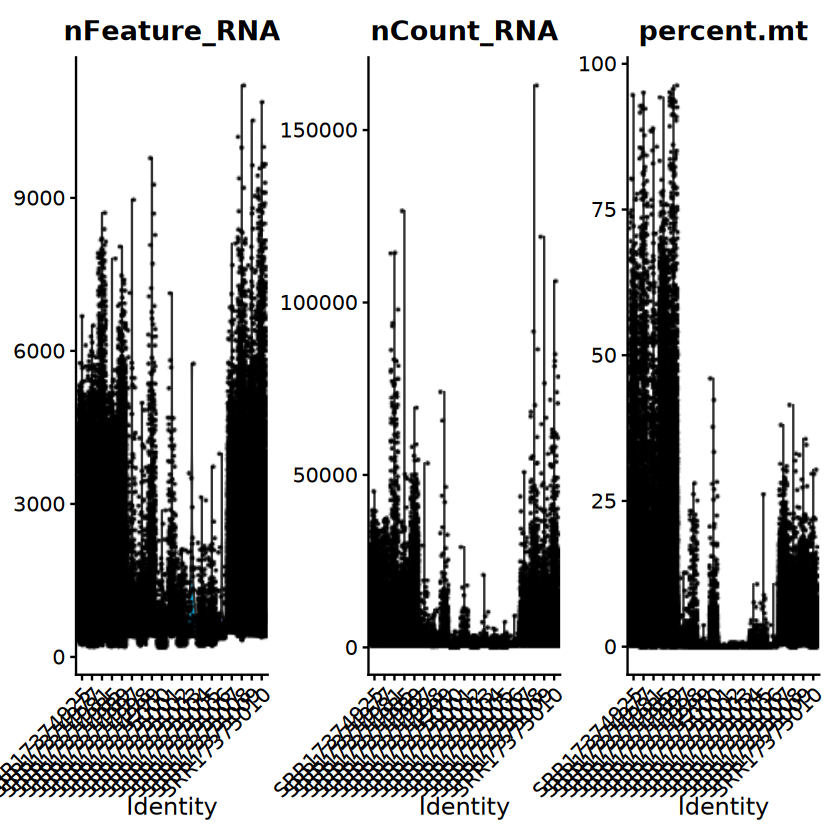

In [7]:
seurat_combined[["percent.mt"]] <- PercentageFeatureSet(seurat_combined, pattern = "^mt-")
VlnPlot(seurat_combined, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [ ]:
# Filter out cells with fewer than 200 genes and genes detected in fewer than 3 cells
seurat_combined <- subset(seurat_combined, subset = nFeature_RNA > 200)

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'i' in selecting a method for function '[': error in evaluating the argument 'x' in selecting a method for function 'rowSums': no slot of name "counts" for this object of class "Assay5"


In [6]:
# Normalize total counts per cell and log-transform
seurat_combined <- NormalizeData(seurat_combined)
# Identify highly variable genes
seurat_combined <- FindVariableFeatures(seurat_combined, selection.method = "vst", nfeatures = 2000)
# Scale the data
seurat_combined <- ScaleData(seurat_combined, features = VariableFeatures(seurat_combined))

Normalizing layer: counts.SRR17374925.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject

Normalizing layer: counts.SRR17374977.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject

Normalizing layer: counts.SRR17374981.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject

Normalizing layer: counts.SRR17374985.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.Seura

In [ ]:
seurat_combined <- RunPCA(seurat_combined, features = VariableFeatures(seurat_combined))
seurat_combined <- FindNeighbors(seurat_combined, dims = 1:20)
seurat_combined <- RunUMAP(seurat_combined, dims = 1:20)
seurat_combined <- FindClusters(seurat_combined, resolution = 1.0)

In [ ]:
# UMAP plot colored by metadata
DimPlot(seurat_combined, group.by = "Diet", label = TRUE, label.size = 3)
DimPlot(seurat_combined, group.by = "Duration", label = TRUE, label.size = 3)
DimPlot(seurat_combined, group.by = "sample", label = TRUE, label.size = 3)

In [ ]:
saveRDS(seurat_combined, file = "mouse_combined_scRNA.rds")